In [163]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
import scipy.stats as stats
%matplotlib inline

# Preliminary Data Cleaning

In [164]:
# writing a helper function to get my Federal Elections Commission data in the right shape
from nameparser import HumanName

def funding_data(df):
    df = df.loc[:,['name','state','district','candidate_election_year','party',
                'incumbent_challenge','receipts','disbursements']]
    df = df[df['party'].str.contains('DEM') | df['party'].str.contains('REP')]
    df.party = df.party.apply(lambda x : x[0])
    df = df.dropna()
    df.district = df.district.astype(int)
    df = df.rename(columns = {'candidate_election_year' : 'year'})
    df.name = df.name.apply(lambda name: " ".join(name.split(', ')[::-1]))
    df['id'] = df.name.apply(lambda name: HumanName(name).last) + ' '+ df.state + ' ' + df.district.astype(str) + ' ' + df.year.astype(str)
    
    return df

In [165]:
# reading data for three elections

fec_2018 = pd.read_csv('totals-2019-10-02T16_25_40.csv')
fec_2016 = pd.read_csv('totals-2019-10-03T13_42_55.csv')
fec_2014 = pd.read_csv('totals-2019-10-04T15_47_25.csv')

In [166]:
fec1 = funding_data(fec_2014)
fec2 = funding_data(fec_2016)
fec3 = funding_data(fec_2018)

In [167]:
fec_df = fec1.append([fec2,fec3])

fec_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6545 entries, 0 to 2455
Data columns (total 9 columns):
name                   6545 non-null object
state                  6545 non-null object
district               6545 non-null int64
year                   6545 non-null int64
party                  6545 non-null object
incumbent_challenge    6545 non-null object
receipts               6545 non-null float64
disbursements          6545 non-null float64
id                     6545 non-null object
dtypes: float64(2), int64(2), object(5)
memory usage: 511.3+ KB


In [168]:
#fec_df.id = fec_df.id + ' ' + fec_df.state + ' ' + fec_df.district.astype(str)

fec_df.head()

,name,state,district,year,party,incumbent_challenge,receipts,disbursements,id
0,CHARLES B MEYER,TX,36,2014,R,O,3500.00,9030.39,MEYER TX 36 2014
1,JUDE ANTHONY TISCORNIA,NJ,8,2014,R,C,0.00,0.00,TISCORNIA NJ 8 2014
2,ANDRE N BARNETT,NY,18,2014,R,C,0.00,0.00,BARNETT NY 18 2014
5,ERIC CANTOR,VA,7,2014,R,I,6649687.01,7699242.10,CANTOR VA 7 2014
6,JOHN LEWIS,MT,0,2014,D,O,1721571.63,1703086.35,LEWIS MT 0 2014


In [169]:
# writing a helper function to transform election results and return data for years of interest
def results_data(df, year, state_dict):
    df.candidatevotes = df.candidatevotes.str.replace(',','').astype(int)
    df = df.loc[:,['candidate','state','district','party','candidatevotes','totalvotes', 'year']]
    df = df = df[df['party'].str.contains('democrat') | df['party'].str.contains('republican')]
    df = df.loc[df['year'] >= year,:]
    df.state = df.state.apply(lambda state: us_state_abbrev[state])
    df = df.rename(columns = {'candidate' : 'name'})
    df.name = df.name.apply(lambda name: name.upper())
    df.name = df.name.replace('__',' ', regex = True)
    df['id'] = df.name.apply(lambda name: HumanName(name).last) + ' ' + df.state + ' ' + df.district.astype(str) + ' ' + df.year.astype(str)
    df.district = df.state + ' ' + df.district.astype(str)
    df = df.drop('state', axis=1)
    return df

In [170]:
results = pd.read_csv('1976-2018-house.csv', encoding = 'unicode_escape')

us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Palau': 'PW',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',}


res_df = results_data(results, 2014, us_state_abbrev)

In [171]:
res_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2496 entries, 25480 to 29632
Data columns (total 7 columns):
name              2496 non-null object
district          2496 non-null object
party             2496 non-null object
candidatevotes    2496 non-null int64
totalvotes        2496 non-null float64
year              2496 non-null int64
id                2496 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 156.0+ KB


In [172]:
res_df.head()

,name,district,party,candidatevotes,totalvotes,year,id
25480,BRADLEY BYRNE,AL 1,republican,103758,152234.0,2014,BYRNE AL 1 2014
25482,BURTON R. LEFLORE,AL 1,democrat,48278,152234.0,2014,LEFLORE AL 1 2014
25483,MARTHA ROBY,AL 2,republican,113103,167952.0,2014,ROBY AL 2 2014
25484,ERICK WRIGHT,AL 2,democrat,54692,167952.0,2014,WRIGHT AL 2 2014
25487,JESSE T. SMITH,AL 3,democrat,52816,156620.0,2014,SMITH AL 3 2014


In [370]:
# writing a helper function to merge dataframes and return a usable one for regression purposes and adding features

def merge_dfs(df1, df2):
    result = pd.merge(df1, df2, how = 'inner', on = 'id')
    result = result.drop(['name_y','district_y','year_y', 'state', 'party_x'], axis = 1)
    result.rename(columns = {'name_x' : 'name', 'district_x' : 'district',
                            'year_x' : 'year', 'party_y' : 'party'}, inplace = True)
    return result

In [371]:
df1 = merge_dfs(res_df, fec_df)

df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2453 entries, 0 to 2452
Data columns (total 10 columns):
name                   2453 non-null object
district               2453 non-null object
candidatevotes         2453 non-null int64
totalvotes             2453 non-null float64
year                   2453 non-null int64
id                     2453 non-null object
party                  2453 non-null object
incumbent_challenge    2453 non-null object
receipts               2453 non-null float64
disbursements          2453 non-null float64
dtypes: float64(3), int64(2), object(5)
memory usage: 210.8+ KB


In [372]:
df1.head()

,name,district,candidatevotes,totalvotes,year,id,party,incumbent_challenge,receipts,disbursements
0,BRADLEY BYRNE,AL 1,103758,152234.0,2014,BYRNE AL 1 2014,R,I,1907597.44,1655998.60
1,BURTON R. LEFLORE,AL 1,48278,152234.0,2014,LEFLORE AL 1 2014,D,C,36974.05,35603.00
2,MARTHA ROBY,AL 2,113103,167952.0,2014,ROBY AL 2 2014,R,I,1098795.10,793565.21
3,JESSE T. SMITH,AL 3,52816,156620.0,2014,SMITH AL 3 2014,D,C,9000.00,9000.00
4,MIKE ROGERS,AL 3,103558,156620.0,2014,ROGERS AL 3 2014,R,I,1107197.22,941431.50


In [373]:
# writing a helper function to populate dataframe with skew data

def add_skew(url):
    tables = pd.read_html(url)
    skew = tables[1]
    skew.District = skew.District.apply(lambda x: x.replace('at-large', '0'))
    skew['district'] = skew.District.apply(lambda x: ' '.join(x.split()[:-1]))
    skew.district.apply(lambda name: name.upper())
    skew.district = skew.district.apply(lambda district: us_state_abbrev[district])
    skew.district = skew.district + ' ' + skew.District.apply(lambda x: x.split()[-1])
    skew.PVI = skew.PVI.apply(lambda x: x.replace('EVEN', 'R+0'))
    skew['favored_party'] = skew.PVI.apply(lambda x: x.split('+')[0])
    skew['skew'] = skew.PVI.apply(lambda x : int(x.split('+')[-1]))
    skew = skew.loc[:,['district', 'favored_party', 'skew']]
    return skew
    

In [374]:
url = 'https://en.wikipedia.org/wiki/Cook_Partisan_Voting_Index'

skew_df = add_skew(url)

skew_df.head()

,district,favored_party,skew
0,AL 1,R,15
1,AL 2,R,16
2,AL 3,R,16
3,AL 4,R,30
4,AL 5,R,18


In [375]:
# merging the dataframes
test = pd.merge(df1,skew_df, on = 'district')

# transforming the skew so it shows whether 
test['party_match'] = test['party'] != test['favored_party']
test['party_match'] = test['party_match'].apply(lambda match : -1 if match else 1)
test['skew'] = test['party_match']*test['skew']
test.head()

,name,district,candidatevotes,totalvotes,year,id,party,incumbent_challenge,receipts,disbursements,favored_party,skew,party_match
0,BRADLEY BYRNE,AL 1,103758,152234.0,2014,BYRNE AL 1 2014,R,I,1907597.44,1655998.60,R,15,1
1,BURTON R. LEFLORE,AL 1,48278,152234.0,2014,LEFLORE AL 1 2014,D,C,36974.05,35603.00,R,-15,-1
2,BRADLEY BYRNE,AL 1,208083,215893.0,2016,BYRNE AL 1 2016,R,I,1367469.77,1172750.28,R,15,1
3,ROBERT KENNEDY JR.,AL 1,89226,242617.0,2018,KENNEDY AL 1 2018,D,C,166845.21,166845.21,R,-15,-1
4,BRADLEY BYRNE,AL 1,153228,242617.0,2018,BYRNE AL 1 2018,R,I,1463187.12,834780.43,R,15,1


In [376]:
# adding a feature that shows whether the election is presidential or midterm
test['presidential_election'] = test['year'] == 2016
test['presidential_election'] = test['presidential_election'].apply(lambda pres: 1 if pres else 0)

test.year.unique()

array([2014, 2016, 2018])

In [377]:
test.head()

,name,district,candidatevotes,totalvotes,year,id,party,incumbent_challenge,receipts,disbursements,favored_party,skew,party_match,presidential_election
0,BRADLEY BYRNE,AL 1,103758,152234.0,2014,BYRNE AL 1 2014,R,I,1907597.44,1655998.60,R,15,1,0
1,BURTON R. LEFLORE,AL 1,48278,152234.0,2014,LEFLORE AL 1 2014,D,C,36974.05,35603.00,R,-15,-1,0
2,BRADLEY BYRNE,AL 1,208083,215893.0,2016,BYRNE AL 1 2016,R,I,1367469.77,1172750.28,R,15,1,1
3,ROBERT KENNEDY JR.,AL 1,89226,242617.0,2018,KENNEDY AL 1 2018,D,C,166845.21,166845.21,R,-15,-1,0
4,BRADLEY BYRNE,AL 1,153228,242617.0,2018,BYRNE AL 1 2018,R,I,1463187.12,834780.43,R,15,1,0


In [378]:
df1 = test

In [379]:
spending = df1.disbursements
fundraising = df1.receipts
votes = df1.candidatevotes
skew = df1.skew

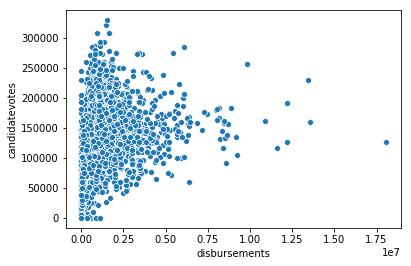

In [380]:
sns.scatterplot(x=spending, y=votes)

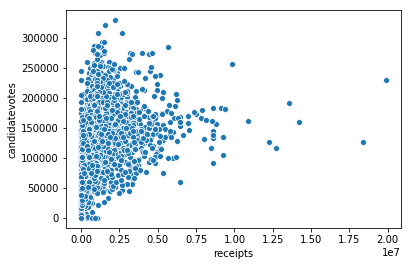

In [381]:
sns.scatterplot(x=fundraising, y=votes)

In [382]:
#sns.scatterplot(x=skew, y=votes)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2453 entries, 0 to 2452
Data columns (total 14 columns):
name                     2453 non-null object
district                 2453 non-null object
candidatevotes           2453 non-null int64
totalvotes               2453 non-null float64
year                     2453 non-null int64
id                       2453 non-null object
party                    2453 non-null object
incumbent_challenge      2453 non-null object
receipts                 2453 non-null float64
disbursements            2453 non-null float64
favored_party            2453 non-null object
skew                     2453 non-null int64
party_match              2453 non-null int64
presidential_election    2453 non-null int64
dtypes: float64(3), int64(5), object(6)
memory usage: 287.5+ KB


# Linear Regression

In [383]:
df1.corr()

,candidatevotes,totalvotes,year,receipts,disbursements,skew,party_match,presidential_election
candidatevotes,1.000000,0.564139,0.265078,0.345279,0.319450,0.542824,0.501070,0.294237
totalvotes,0.564139,1.000000,0.390834,0.120713,0.127683,-0.088990,-0.069055,0.472306
year,0.265078,0.390834,1.000000,0.126495,0.138900,-0.028210,-0.031487,-0.018485
receipts,0.345279,0.120713,0.126495,1.000000,0.977801,0.248612,0.259006,-0.091183
disbursements,0.319450,0.127683,0.138900,0.977801,1.000000,0.226672,0.234002,-0.099319
skew,0.542824,-0.088990,-0.028210,0.248612,0.226672,1.000000,0.830514,0.001198
party_match,0.501070,-0.069055,-0.031487,0.259006,0.234002,0.830514,1.000000,-0.004462
presidential_election,0.294237,0.472306,-0.018485,-0.091183,-0.099319,0.001198,-0.004462,1.000000


In [384]:
dummies = pd.get_dummies(df1['incumbent_challenge'], drop_first = True)

dummies2 = pd.get_dummies(df1['party'], drop_first = True)

df2 = pd.concat([df1, dummies], axis = 1)

df3 = pd.concat([df2, dummies2], axis = 1)

df3.head()

,name,district,candidatevotes,totalvotes,year,id,party,incumbent_challenge,receipts,disbursements,favored_party,skew,party_match,presidential_election,I,O,R
0,BRADLEY BYRNE,AL 1,103758,152234.0,2014,BYRNE AL 1 2014,R,I,1907597.44,1655998.60,R,15,1,0,1,0,1
1,BURTON R. LEFLORE,AL 1,48278,152234.0,2014,LEFLORE AL 1 2014,D,C,36974.05,35603.00,R,-15,-1,0,0,0,0
2,BRADLEY BYRNE,AL 1,208083,215893.0,2016,BYRNE AL 1 2016,R,I,1367469.77,1172750.28,R,15,1,1,1,0,1
3,ROBERT KENNEDY JR.,AL 1,89226,242617.0,2018,KENNEDY AL 1 2018,D,C,166845.21,166845.21,R,-15,-1,0,0,0,0
4,BRADLEY BYRNE,AL 1,153228,242617.0,2018,BYRNE AL 1 2018,R,I,1463187.12,834780.43,R,15,1,0,1,0,1


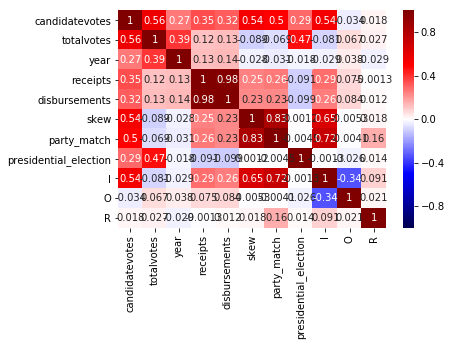

In [385]:
sns.heatmap(df3.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1)

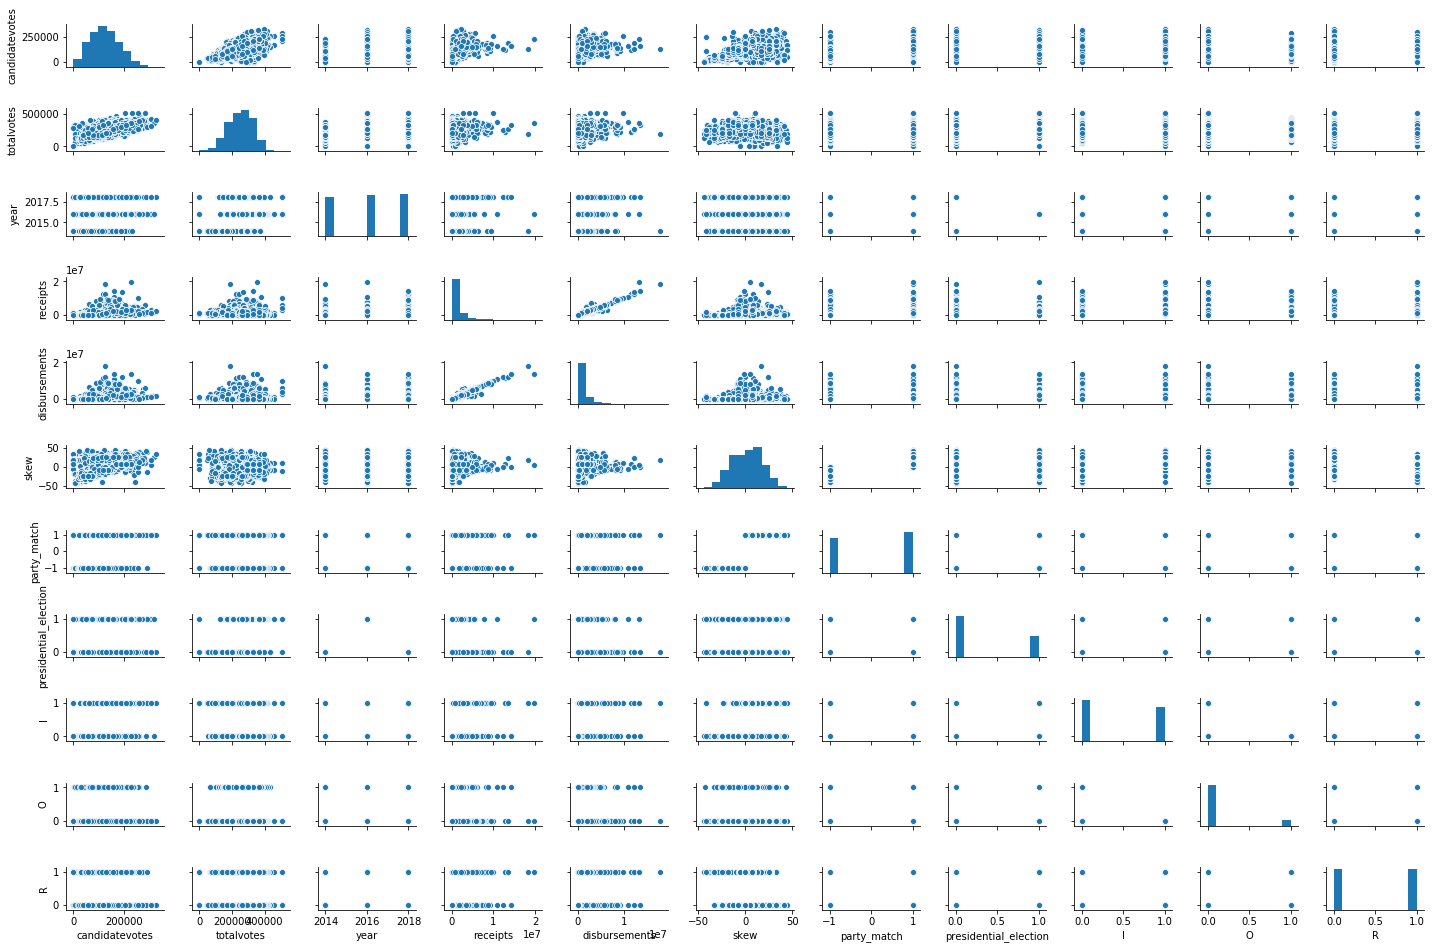

In [386]:
sns.pairplot(df3, height=1.2, aspect=1.5);

In [472]:
y, X = patsy.dmatrices('candidatevotes ~ receipts + disbursements + incumbent_challenge + skew + party + presidential_election',
                       data=df3, return_type="dataframe")

model = sm.OLS(y, X)

fit = model.fit()

fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         candidatevotes   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     336.8
Date:                Wed, 09 Oct 2019   Prob (F-statistic):               0.00
Time:                        14:03:44   Log-Likelihood:                -29556.
No. Observations:                2453   AIC:                         5.913e+04
Df Residuals:                    2445   BIC:                         5.917e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                 8.285e+04   1801.683     45.986      0.000    7.93e+04    8.64e+04
incumbent_challenge[T.I]   3.84e+04   2564.933     14.971      0.000    3.34e+04    4.34e+04
incumbent_challenge[T.O]  1.303e+04   2932.864      4.441      0.000    7274.111    1.88e+04
party[T.R]               -2620.1929   1693.089     -1.548      0.122   -5940.229     699.844
receipts                     0.0095      0.003      3.711      0.000       0.004       0.015
disbursements               -0.0022      0.003     -0.834      0.405      -0.007       0.003
skew                       993.1159     71.834     13.825      0.000     852.253    1133.979
presidential_election     3.861e+04   1781.411     21.674      0.000    3.51e+04    4.21e+04
==============================================================================
Omnibus:                      116.462   Durbin-Watson:                   1.167
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              233.447
Skew:                          -0.331   Prob(JB):                     2.03e-51
Kurtosis:                       4.359   Cond. No.                     1.17e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.17e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Evaluation of preliminary linear regression

* enter evaluations here

Now I have a relatively ok OLS standard regression. Going to check on some of the regression assumptions to get a better idea of how the model is performing

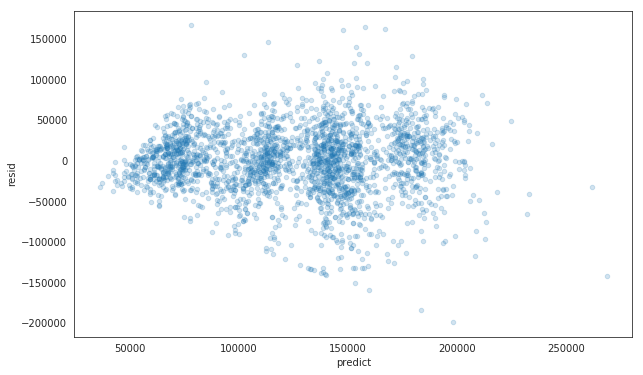

In [466]:
df3['predict'] = fit.predict(X)
df3['resid'] = df3.candidatevotes-df3.predict
with sns.axes_style('white'):
    plot = df3.plot(kind='scatter',
                  x = 'predict', y='resid', alpha=0.2, figsize=(10,6))

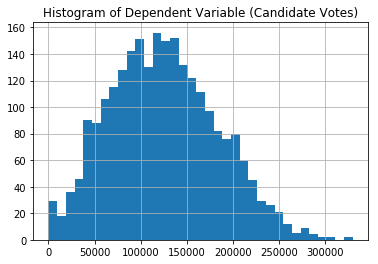

In [467]:
df3.candidatevotes.hist(bins=35)
plt.title('Histogram of Dependent Variable (Candidate Votes)');

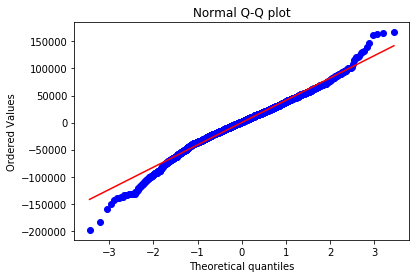

In [468]:
import scipy.stats as stats
stats.probplot(df3['resid'], dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

The target variable looks nice and normally distributed for the most part. But it seems like the model is performing better at the low range of vote totals than at the higher end. That is, there is some evidence of heteroskedasticity in my model! However, it seems like the model meets the assumptions of linear regression to a relatively satisfactory degree. 

I want to see how adding total votes impacts the model. It isn't an ideal feature to use, given that I'd like to focus on features that we know __before__ voting occurs, given the business use case I have in mind.

In [473]:
y2, X2 = patsy.dmatrices('candidatevotes ~ disbursements + receipts + incumbent_challenge + skew + party + presidential_election + totalvotes',
                       data=df3, return_type="dataframe")

model = sm.OLS(y2, X2)

fit = model.fit()

fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         candidatevotes   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     950.7
Date:                Wed, 09 Oct 2019   Prob (F-statistic):               0.00
Time:                        14:04:41   Log-Likelihood:                -28649.
No. Observations:                2453   AIC:                         5.732e+04
Df Residuals:                    2444   BIC:                         5.737e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                -1.782e+04   2311.677     -7.710      0.000   -2.24e+04   -1.33e+04
incumbent_challenge[T.I]  4.228e+04   1774.694     23.824      0.000    3.88e+04    4.58e+04
incumbent_challenge[T.O]  8452.9561   2029.380      4.165      0.000    4473.474    1.24e+04
party[T.R]               -4220.0541   1170.820     -3.604      0.000   -6515.955   -1924.153
disbursements               -0.0079      0.002     -4.326      0.000      -0.011      -0.004
receipts                     0.0104      0.002      5.860      0.000       0.007       0.014
skew                      1211.9872     49.838     24.318      0.000    1114.257    1309.717
presidential_election     1822.3503   1422.293      1.281      0.200    -966.674    4611.374
totalvotes                   0.4682      0.009     51.695      0.000       0.450       0.486
==============================================================================
Omnibus:                      574.034   Durbin-Watson:                   1.663
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5831.235
Skew:                          -0.807   Prob(JB):                         0.00
Kurtosis:                      10.379   Cond. No.                     1.27e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.27e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

It performs much better! But I will have to think about whether I should include this feature. Both have very low F-statistics, and similar Log-Likelihoods. Interestingly, the model with total votes gives a slightly higher p-value for the presidential_election feature, although it is still below .05. This makes sense, given that both features are ways of predicting total turnout. Obviously, the total votes cast in the district during a given election is a much more reliable indicator of turnout (adding them up, you get total votes cast in the country on house candidates) than midterm/presidential election, which is just a predictor. 

Furthermore, when I didn't include total votes, the party feature had a p-value of .14, which suggested I should reject it. With the total votes, however, the p-value dropped to 0. I'm not exactly sure why that would have happened! 

Many of the other evaluative scores are similar. The second model, with total votes added in, has a slightly more optimal Durbin Watson score, which indicates less autocorrelation in that model — although I don't think that the difference should carry much weight. I would be happier if it were closer to 2, though. At the end of the day, the most important score is the adjusted r^2 — I'm not really getting penalized for having too many features, so I doubt that I am overfitting. I am going to continue with the model that includes total votes, for now.

__The most important thing is to address the very high condition number!__

In [474]:
y, X = patsy.dmatrices('candidatevotes ~ receipts + totalvotes + incumbent_challenge + skew + presidential_election',
                       data=df3, return_type="dataframe")

model = sm.OLS(y, X)

fit = model.fit()

fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         candidatevotes   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     1246.
Date:                Wed, 09 Oct 2019   Prob (F-statistic):               0.00
Time:                        14:04:49   Log-Likelihood:                -28666.
No. Observations:                2453   AIC:                         5.735e+04
Df Residuals:                    2446   BIC:                         5.739e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                -1.904e+04   2287.822     -8.323      0.000   -2.35e+04   -1.46e+04
incumbent_challenge[T.I]  4.204e+04   1762.772     23.852      0.000    3.86e+04    4.55e+04
incumbent_challenge[T.O]  7869.5381   2036.065      3.865      0.000    3876.949    1.19e+04
receipts                     0.0030      0.000      7.441      0.000       0.002       0.004
totalvotes                   0.4647      0.009     51.096      0.000       0.447       0.483
skew                      1224.4060     50.034     24.472      0.000    1126.293    1322.519
presidential_election     2277.5615   1428.021      1.595      0.111    -522.694    5077.817
==============================================================================
Omnibus:                      576.444   Durbin-Watson:                   1.667
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5926.503
Skew:                          -0.808   Prob(JB):                         0.00
Kurtosis:                      10.441   Cond. No.                     9.25e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.25e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

I got the condition number down, but it is still high... this model suggests I drop presidential vs. midterm election as a feature. It looks like total votes will be better to use.

In [475]:
y, X = patsy.dmatrices('candidatevotes ~ receipts + totalvotes + incumbent_challenge + skew',
                       data=df3, return_type="dataframe")

model = sm.OLS(y, X)

fit = model.fit()

fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         candidatevotes   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     1493.
Date:                Wed, 09 Oct 2019   Prob (F-statistic):               0.00
Time:                        14:09:32   Log-Likelihood:                -28668.
No. Observations:                2453   AIC:                         5.735e+04
Df Residuals:                    2447   BIC:                         5.738e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                -1.998e+04   2212.219     -9.030      0.000   -2.43e+04   -1.56e+04
incumbent_challenge[T.I]  4.212e+04   1762.671     23.896      0.000    3.87e+04    4.56e+04
incumbent_challenge[T.O]  7757.0285   2035.484      3.811      0.000    3765.579    1.17e+04
receipts                     0.0029      0.000      7.269      0.000       0.002       0.004
totalvotes                   0.4720      0.008     59.834      0.000       0.456       0.487
skew                      1228.8480     49.972     24.591      0.000    1130.857    1326.839
==============================================================================
Omnibus:                      577.205   Durbin-Watson:                   1.672
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6146.250
Skew:                          -0.799   Prob(JB):                         0.00
Kurtosis:                      10.588   Cond. No.                     9.10e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.1e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [485]:
y, X = patsy.dmatrices('candidatevotes ~ incumbent_challenge + skew + presidential_election',
                       data=df3, return_type="dataframe")

model = sm.OLS(y, X)

fit = model.fit()

fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         candidatevotes   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.453
Method:                 Least Squares   F-statistic:                     507.8
Date:                Wed, 09 Oct 2019   Prob (F-statistic):          3.80e-319
Time:                        14:15:38   Log-Likelihood:                -29642.
No. Observations:                2453   AIC:                         5.929e+04
Df Residuals:                    2448   BIC:                         5.932e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                 8.746e+04   1667.040     52.464      0.000    8.42e+04    9.07e+04
incumbent_challenge[T.I]  4.582e+04   2549.748     17.969      0.000    4.08e+04    5.08e+04
incumbent_challenge[T.O]  1.935e+04   2981.214      6.492      0.000    1.35e+04    2.52e+04
skew                      1029.2109     74.142     13.882      0.000     883.824    1174.598
presidential_election     3.648e+04   1834.636     19.881      0.000    3.29e+04    4.01e+04
==============================================================================
Omnibus:                      107.769   Durbin-Watson:                   1.185
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              223.079
Skew:                          -0.295   Prob(JB):                     3.62e-49
Kurtosis:                       4.354   Cond. No.                         67.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [487]:
y, X = patsy.dmatrices('candidatevotes ~ receipts + totalvotes',
                       data=df3, return_type="dataframe")

model = sm.OLS(y, X)

fit = model.fit()

fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         candidatevotes   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     803.9
Date:                Wed, 09 Oct 2019   Prob (F-statistic):          3.79e-269
Time:                        14:23:29   Log-Likelihood:                -29765.
No. Observations:                2453   AIC:                         5.954e+04
Df Residuals:                    2450   BIC:                         5.955e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8862.5028   3202.081      2.768      0.006    2583.438    1.51e+04
receipts       0.0102      0.001     17.787      0.000       0.009       0.011
totalvotes     0.4093      0.012     33.526      0.000       0.385       0.433
==============================================================================
Omnibus:                       24.886   Durbin-Watson:                   2.151
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.162
Skew:                           0.191   Prob(JB):                     7.67e-07
Kurtosis:                       3.361   Cond. No.                     7.19e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.19e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Standardization and Feature Engineering

In [432]:
# standardizing my features
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [433]:
df3.columns

Index(['name', 'district', 'candidatevotes', 'totalvotes', 'year', 'id',
       'party', 'incumbent_challenge', 'receipts', 'disbursements',
       'favored_party', 'skew', 'party_match', 'presidential_election', 'I',
       'O', 'R', 'predict', 'resid'],
      dtype='object')

In [434]:
# separating my target value from my features that should be standardized
X = df3.loc[:,['disbursements','receipts', 'skew', 'I','O','R']]

y = df3['candidatevotes']

In [435]:
# splitting into training and test samples
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

In [436]:
X_train.shape

(1471, 7)

In [515]:
X_val.shape

(491, 6)

In [438]:
X_test.shape

(491, 7)

In [439]:
# fitting Standard Scaler to training set

std = StandardScaler()
std.fit(X_train.values)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [440]:
# applying the standardization to training and test sets

X_tr = std.transform(X_train.values)

X_te = std.transform(X_test.values)

([array([  0.,   0., 931., 387.,  96.,  35.,   6.,  12.,   2.,   2.]),
  array([  0.,   0., 898., 416., 101.,  34.,   6.,  13.,   2.,   1.]),
  array([ 23., 188., 474., 572., 210.,   3.,   1.,   0.,   0.,   0.]),
  array([ 13., 192., 499., 570., 187.,  10.,   0.,   0.,   0.,   0.]),
  array([  0.,   0., 803.,   0., 668.,   0.,   0.,   0.,   0.,   0.]),
  array([   0.,    0., 1291.,    0.,    0.,  180.,    0.,    0.,    0.,
            0.]),
  array([  0.,   0., 741., 730.,   0.,   0.,   0.,   0.,   0.,   0.])],
 array([-3.37079299, -2.25626664, -1.14174028, -0.02721393,  1.08731242,
         2.20183877,  3.31636512,  4.43089147,  5.54541782,  6.65994417,
         7.77447052]),
 <a list of 7 Lists of Patches objects>)

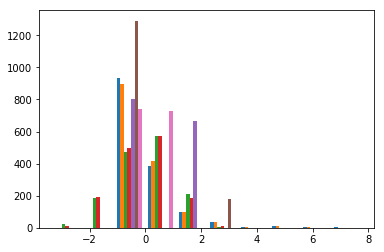

In [441]:
plt.hist(X_tr)

In [442]:
# fitting a LASSO model onto standardized data

lasso_model = Lasso(alpha = 1000)
lasso_model.fit(X_tr,y_train)

Lasso(alpha=1000, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [443]:
list(zip(X_train.columns, lasso_model.coef_))

[('disbursements', 0.0),
 ('receipts', 4812.777977410824),
 ('totalvotes', 33633.79399495664),
 ('skew', 16542.217020127617),
 ('I', 22492.20686718687),
 ('O', 1402.0419649806288),
 ('R', -1170.6297757380612)]

In [444]:
lasso_model2 = Lasso(alpha = 100)
lasso_model2.fit(X_tr,y_train)
list(zip(X_train.columns, lasso_model2.coef_))

[('disbursements', -8177.388280465017),
 ('receipts', 13148.628200471048),
 ('totalvotes', 34675.409634306816),
 ('skew', 16402.390720724055),
 ('I', 23813.506923580775),
 ('O', 2809.462691876271),
 ('R', -2251.3519040002143)]

Interesting! When you run regularization on the model, the coefficient for disbursements, or actual money spent, zeroes out. But when you run it with a lower alpha, you can see a strongly negative coefficient for disbursements. That means that the model predicts that the more money you spend, the fewer votes you get. This tracks with the idea that more competitive races have more spending in them, which is backed up by academic literature. Also, this suggests that receipts is actually a better predictor of a candidate's performance in an election.

Secondly, this suggests that the "party" variable should possibly be dropped, because it eventually gets zeroed out. It also had a relatively high p-value in my preliminary model. I had thought that it might be useful, because overall, democratic candidates receive more votes than republicans. (This is reflected in the fact that being a Republican has a negative coefficient at low alpha-values.) I will tune the alpha value through validation below.

In [445]:
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))

In [448]:
# Tuning regularization strength via validation

alphalist = 10**(np.linspace(-2,4,1000))
err_vec_val = np.zeros(len(alphalist))
err_vec_train = np.zeros(len(alphalist))
selected_columns = ['disbursements','receipts','skew','totalvotes','I','O','R']


for i,curr_alpha in enumerate(alphalist):

    steps = [('standardize', StandardScaler()), 
             ('lasso', Lasso(alpha = curr_alpha))]

    pipe = Pipeline(steps)
    pipe.fit(X_train.loc[:,selected_columns].values, y_train)
    
    val_set_pred = pipe.predict(X_val.loc[:,selected_columns].values)
    err_vec_val[i] = mae(y_val, val_set_pred)

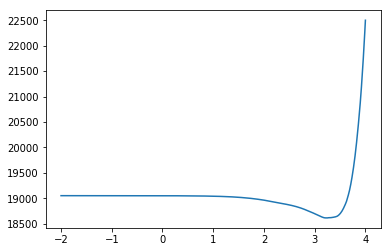

In [449]:
plt.plot(np.log10(alphalist), err_vec_val)

In [450]:
np.min(err_vec_val)

18617.121768522517

In [451]:
alphalist[np.argmin(err_vec_val)]

1750.8270317357233

In [452]:
#finding coefficients given the optimal LASSO alpha number
lasso_model3 = Lasso(alpha = 124.19213527017847)
lasso_model3.fit(X_tr,y_train)
list(zip(X_train.columns, lasso_model3.coef_))

[('disbursements', -6936.2776727688215),
 ('receipts', 11913.954185261453),
 ('totalvotes', 34639.27449435233),
 ('skew', 16412.82357572089),
 ('I', 23806.103007138394),
 ('O', 2777.7850417708405),
 ('R', -2237.2809343126937)]

It looks like in the end, I should drop the disbursements feature or combine it with the disbursements in some way. That might help me with my large condition number. 

Clearly there are also missing features that could explain some more of the variation left in the data, but I'm wondering whether polling would do that — my use case assumes the absence of reliable, complete polling for 435 races around the country.

## Ridge for dealing with multicolinearity

In [495]:
Xr = df3.loc[:,['receipts', 'totalvotes', 'skew', 'I','O','R']]
y = df3['candidatevotes']

X_train_val, X_test, y_train_val, y_test = train_test_split(Xr, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

std = StandardScaler()
std.fit(X_train.values)

X_tr = std.transform(X_train.values)
X_te = std.transform(X_test.values)

lr_model_ridge = Ridge(alpha = 1)
lr_model_ridge.fit(X_tr, y_train)

list(zip(X_train.columns, lr_model_ridge.coef_))

[('receipts', 5092.140837312108),
 ('totalvotes', 34692.52254850203),
 ('skew', 16448.801308476723),
 ('I', 24183.470668863953),
 ('O', 3009.6532652301476),
 ('R', -2498.593868917105)]

In [509]:
Xr = df3.loc[:,['receipts', 'totalvotes', 'skew', 'I','O','R']]
y = df3['candidatevotes']

std = StandardScaler()
std.fit(Xr.values)

X_tr = std.transform(Xr.values)

lr_model_ridge = Ridge(alpha = 1)
lr_model_ridge.fit(X_tr, y)

list(zip(X_train.columns, lr_model_ridge.coef_))

[('receipts', 36228.35124065234),
 ('totalvotes', 21278.052410083823),
 ('skew', 20561.841750707485)]

In [513]:
Xr = df3.loc[:,['receipts', 'disbursements', 'totalvotes', 'skew', 'I','O','R']]
y = df3['candidatevotes']

std = StandardScaler()
std.fit(Xr.values)

X_tr = std.transform(Xr.values)

model = sm.OLS(y, X_tr)

fit = model.fit()

fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         candidatevotes   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     54.19
Date:                Wed, 09 Oct 2019   Prob (F-statistic):           2.80e-72
Time:                        15:28:41   Log-Likelihood:                -32327.
No. Observations:                2453   AIC:                         6.467e+04
Df Residuals:                    2446   BIC:                         6.471e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          1.662e+04   1.26e+04      1.317      0.188   -8125.177    4.14e+04
x2         -1.235e+04   1.25e+04     -0.989      0.323   -3.68e+04    1.21e+04
x3          3.558e+04   2635.688     13.501      0.000    3.04e+04    4.08e+04
x4          1.961e+04   3594.013      5.456      0.000    1.26e+04    2.67e+04
x5          2.108e+04   3956.959      5.328      0.000    1.33e+04    2.88e+04
x6          2704.1888   2936.205      0.921      0.357   -3053.517    8461.894
x7         -2108.8016   2620.931     -0.805      0.421   -7248.275    3030.672
==============================================================================
Omnibus:                      574.317   Durbin-Watson:                   0.083
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6009.060
Skew:                          -0.799   Prob(JB):                         0.00
Kurtosis:                      10.499   Cond. No.                         10.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [514]:
lr.fit(X_tr, y)

lr.score(X_tr,y)

0.7566441679284144

# Polynomial Features and Further Feature Engineering

* it looks like the features all should remain, so I want to look at whether adding polynomial features would increase the performance of the model

In [453]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [456]:
#first doing a linear regression with sklearn

lr = LinearRegression()

X = df3[['disbursements','receipts','totalvotes','I' ,'O','R','skew','presidential_election']]

y = df3['candidatevotes']

lr.fit(X, y)

lr.score(X,y)

0.7568075237396698

In [457]:
poly_features = PolynomialFeatures(degree = 3)
x_poly = poly_features.fit_transform(X)
poly_reg3 = lr.fit(x_poly, y)
y_poly_pred = lr.predict(x_poly)
lr.score(x_poly, y)


0.8241006702760989

In [458]:
poly_features = PolynomialFeatures(degree = 2)
x_poly = poly_features.fit_transform(X)
poly_reg2 = lr.fit(x_poly, y)
y_poly_pred = lr.predict(x_poly)
lr.score(x_poly, y)
#lr.coef_
#lr.intercept_

0.8186634986646513

In [459]:
poly_features = PolynomialFeatures(degree = 4)
x_poly = poly_features.fit_transform(X)
poly_reg4 = lr.fit(x_poly, y)
y_poly_pred = lr.predict(x_poly)
lr.score(x_poly, y)

0.7561522890424826

It looks like polynomial features of the second degree bump up the r^2 value of my model by a good amount, without going overboard by adding third-degree features.